# Kaggle : Walmart Recruiting - Store Sales Forecasting

by Chisako Tani, 2021-06-01

---

### 本レポートについて

本レポートは、Kaggleにおいて2014年に行われた、45店舗の売上を予測するコンペを題材にしてデータ分析を行い、その結果を報告することを目的とする。

メインページ:
* [kaggle Walmart Recruiting - Store Sales Forecasting](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/overview)  

参考資料:  
* [kernel-1: Walmart - Store Sales Forecasting Problem](https://www.kaggle.com/marianadehon/walmart-store-sales-forecasting)  
* [kernel-2](https://www.kaggle.com/avelinocaio/walmart-store-sales-forecasting)  
* [forum: Do you re-train on the whole dataset after validating the model?](https://www.kaggle.com/general/9831)

### 目次

0. [Preparation](#0.-Preparation)  

1. [Exploratory Data Analysis](#1.-Exploratory-Data-Analysis)  
    1.1 [各ファイルのデータ内容、統計値、欠損値、データ範囲（期間）を確認](#1.1-各ファイルのデータ内容、統計値、欠損値、データ範囲（期間）を確認)  
    1.2 [ファイルマージ](#1.2-ファイルマージ)  
    1.3 [データの可視化](#1.3-データの可視化)  
    
2. [Model Building](#2.-Model-Building)  
    2.1 [各アルゴリズムの初期評価](#2.1-各アルゴリズムの初期評価)  
    2.2 [特徴量エンジニアリング](#2.2-特徴量エンジニアリング)  
    2.3 [パラメータチューニング](#2.3-パラメータチューニング)  
    2.4 [Train-Validの分割比率](#2.4-Train-Validの分割比率)  
    2.5 [Testデータでの評価](#2.5-Testデータでの評価)  
    2.6 [結果と最終モデル](#2.6-結果と最終モデル)  
    
3. [Final Output & Score](#3.-Final-Output-&-Score)  
    3.1 [最終予測値の出力とモデルの保存](#3.1-最終予測値の出力とモデルの保存)  
    3.2 [スコアの確認](#3.2-スコアの確認)  
4. [Conclusion](#4.-Conclusion)  
    4.1 [考察](#4.1-考察)  
    4.2 [課題と改善点](#4.2-課題と改善点)

---

## 0. Preparation

このセクションでは、必要ライブラリのインポートとデータの読み込みを行う。

#### ライブラリの読み込み

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import pickle
from datetime import datetime

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

#### ファイルの読み込み

In [2]:
main_dir = "data"
train_original = pd.read_csv("%s/train.csv"% main_dir)
test_original = pd.read_csv("%s/test.csv"% main_dir)
features = pd.read_csv("%s/features.csv"% main_dir)
stores = pd.read_csv("%s/stores.csv"% main_dir)

---

## 1. Exploratory Data Analysis

### 1.1 各ファイルのデータ内容、統計値、欠損値、データ範囲（期間）を確認

#### train.csv

In [3]:
train_original.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [4]:
train_original.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object

In [5]:
train_original.shape

(421570, 5)

In [6]:
train_original.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [7]:
train_original.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


* Weekly_Salesカラムにマイナス値あり
* 75%地点と最大値の差が大きい

In [8]:
# マイナス値の件数を確認
train_original[train_original['Weekly_Sales'] <= 0]['Weekly_Sales'].count()

1358

In [9]:
# Dateカラムを文字列からdatetime型に変換
train_original['Date'] = pd.to_datetime(train_original['Date'])
print(min(train_original['Date']))
print(max(train_original['Date']))

2010-02-05 00:00:00
2012-10-26 00:00:00


#### test.csv

In [10]:
test_original.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [11]:
test_original.dtypes

Store         int64
Dept          int64
Date         object
IsHoliday      bool
dtype: object

In [12]:
test_original.shape

(115064, 4)

In [13]:
test_original.isnull().sum()

Store        0
Dept         0
Date         0
IsHoliday    0
dtype: int64

In [14]:
test_original.describe()

,Store,Dept
count,115064.000000,115064.000000
mean,22.238207,44.339524
std,12.809930,30.656410
min,1.000000,1.000000
25%,11.000000,18.000000
50%,22.000000,37.000000
75%,33.000000,74.000000
max,45.000000,99.000000


* Deptの平均値がtrain.csvとわずかに異なる

In [15]:
# Dateカラムを文字列からdatetime型に変換
test_original['Date'] = pd.to_datetime(test_original['Date'])
print(min(test_original['Date']))
print(max(test_original['Date']))

2012-11-02 00:00:00
2013-07-26 00:00:00


#### features.csv

In [16]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [17]:
features.dtypes

Store             int64
Date             object
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
IsHoliday          bool
dtype: object

In [18]:
features.shape

(8190, 12)

In [19]:
features.isnull().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

* MarkDown1-5,CPI,Unemploymentに欠損値あり

In [20]:
features.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


* MarkDown1-3,5にマイナス値あり

In [21]:
# マイナス値の件数を確認
print(features[features['MarkDown1'] <= 0]['MarkDown1'].count())
print(features[features['MarkDown2'] <= 0]['MarkDown2'].count())
print(features[features['MarkDown3'] <= 0]['MarkDown3'].count())
print(features[features['MarkDown5'] <= 0]['MarkDown5'].count())

4
28
14
2


In [22]:
# Dateカラムを文字列からdatetime型に変換
features['Date'] = pd.to_datetime(features['Date'])
print(min(features['Date']))
print(max(features['Date']))

2010-02-05 00:00:00
2013-07-26 00:00:00


* feature.csvにはtrainデータ・testデータの両方の期間のデータを含む

#### stores.csv

In [23]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [24]:
stores.dtypes

Store     int64
Type     object
Size      int64
dtype: object

In [25]:
stores.shape

(45, 3)

In [26]:
stores.describe()

,Store,Size
count,45.000000,45.000000
mean,23.000000,130287.600000
std,13.133926,63825.271991
min,1.000000,34875.000000
25%,12.000000,70713.000000
50%,23.000000,126512.000000
75%,34.000000,202307.000000
max,45.000000,219622.000000


### 1.2 ファイルマージ

#### train + features + stores

In [27]:
# 元となる売上データ基準でマージするのでleftを指定する
# IsHolidayは重複するので、除外した状態でマージ
train_merged = pd.merge(train_original, stores, on='Store', how='left')
train_merged = pd.merge(train_merged, features.drop(['IsHoliday'], axis=1), on=['Store', 'Date'], how='left')

In [28]:
train_merged.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [29]:
train_merged.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
Type                    object
Size                     int64
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
dtype: object

In [30]:
train_merged.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
dtype: int64

* featureデータ確認時は'CPI'と'Unemployment'にNaN値が含まれていたが、Merge後のtrainデータには含まれていない

In [31]:
train_merged.nunique()

Store               45
Dept                81
Date               143
Weekly_Sales    359464
IsHoliday            2
Type                 3
Size                40
Temperature       3528
Fuel_Price         892
MarkDown1         2277
MarkDown2         1499
MarkDown3         1662
MarkDown4         1944
MarkDown5         2293
CPI               2145
Unemployment       349
dtype: int64

#### test + feature + stores

In [32]:
# testデータも同様の方法でmergeする
test_merged = pd.merge(test_original, stores, on='Store', how='left')
test_merged = pd.merge(test_merged, features.drop(['IsHoliday'], axis=1), on=['Store', 'Date'], how='left')

In [33]:
test_merged.head()

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573
1,1,1,2012-11-09,False,A,151315,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573
2,1,1,2012-11-16,False,A,151315,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573
3,1,1,2012-11-23,True,A,151315,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573
4,1,1,2012-11-30,False,A,151315,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573


In [34]:
test_merged.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
IsHoliday                 bool
Type                    object
Size                     int64
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
dtype: object

In [35]:
test_merged.isnull().sum()

Store               0
Dept                0
Date                0
IsHoliday           0
Type                0
Size                0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI             38162
Unemployment    38162
dtype: int64

* 'CPI'と'Unemployment'のNaN値は全てtestデータ側に含まれている

In [36]:
train_merged.nunique()

Store               45
Dept                81
Date               143
Weekly_Sales    359464
IsHoliday            2
Type                 3
Size                40
Temperature       3528
Fuel_Price         892
MarkDown1         2277
MarkDown2         1499
MarkDown3         1662
MarkDown4         1944
MarkDown5         2293
CPI               2145
Unemployment       349
dtype: int64

### 1.3 データの可視化

#### Typeごとの店舗数

<AxesSubplot:xlabel='Type', ylabel='count'>

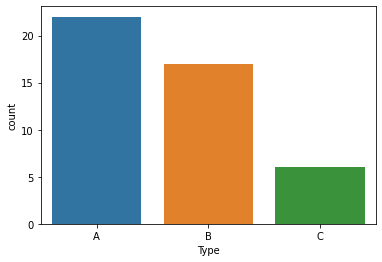

In [37]:
sns.countplot(x='Type', data=stores)

* Type:Aの店舗が一番多く、B、Cと続く

#### Typeごとの店舗サイズ

<AxesSubplot:xlabel='Type', ylabel='Size'>

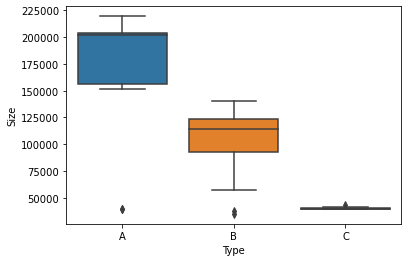

In [38]:
sns.boxplot(x='Type', y='Size', data=stores)

* A:大規模、B:中規模、C:小規模

#### 店舗あたりのDept数

In [39]:
temp_df = train_merged[['Store', 'Dept']].drop_duplicates().reset_index(drop=True)
temp_df.groupby('Store').count()

,Dept
Store,
1,77
2,78
3,72
4,78
5,72
6,77
7,76
8,76
9,73


* 店舗によってDept数にバラツキがある
* 総Dept数は81なので、全Deptを持つ店舗は存在しない

#### 日別の売上推移（平均）

In [40]:
train_eda = train_merged.copy()

<AxesSubplot:xlabel='Date', ylabel='Weekly_Sales'>

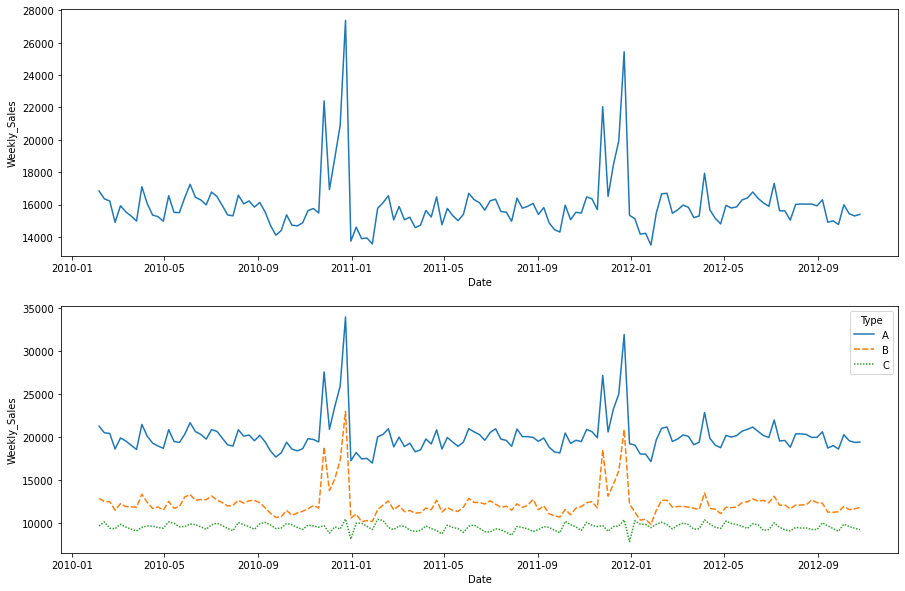

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(15,10))
sns.lineplot(x='Date', y='Weekly_Sales', data=train_eda, ax=ax[0], ci=None)
sns.lineplot(x='Date', y='Weekly_Sales', data=train_eda, hue='Type', style='Type', ax=ax[1],ci=None)

* 2010年、2011年ともに、11月末、12月末に顕著な増加見られる(=Thanksgiving、Christmas)
* TypeごとではA、Bは同じ傾向だが、Cに関しては11月末、12月末の増加は見られない

#### 店別、Dept別、週番号別の売上

<AxesSubplot:xlabel='Dept', ylabel='Weekly_Sales'>

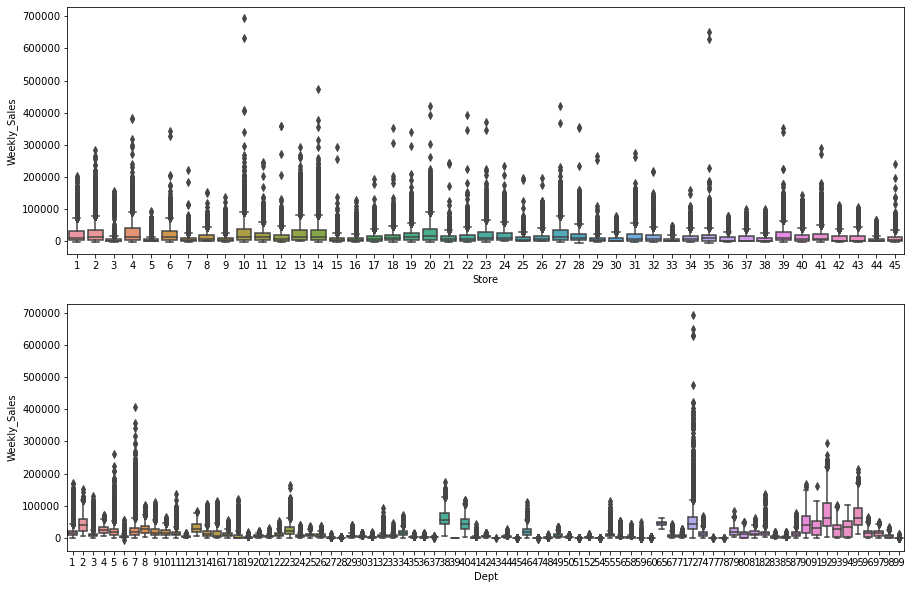

In [42]:
fig, ax = plt.subplots(2, 1, figsize=(15,10))
sns.boxplot(x='Store', y='Weekly_Sales', data=train_eda, ax=ax[0])
sns.boxplot(x='Dept', y='Weekly_Sales', data=train_eda, ax=ax[1])

* 全体的に上側の外れ値が多い（＝極端に売上の多い店・Deptがある）
* Deptにより売上にかなりの差がある

<AxesSubplot:xlabel='Week', ylabel='Weekly_Sales'>

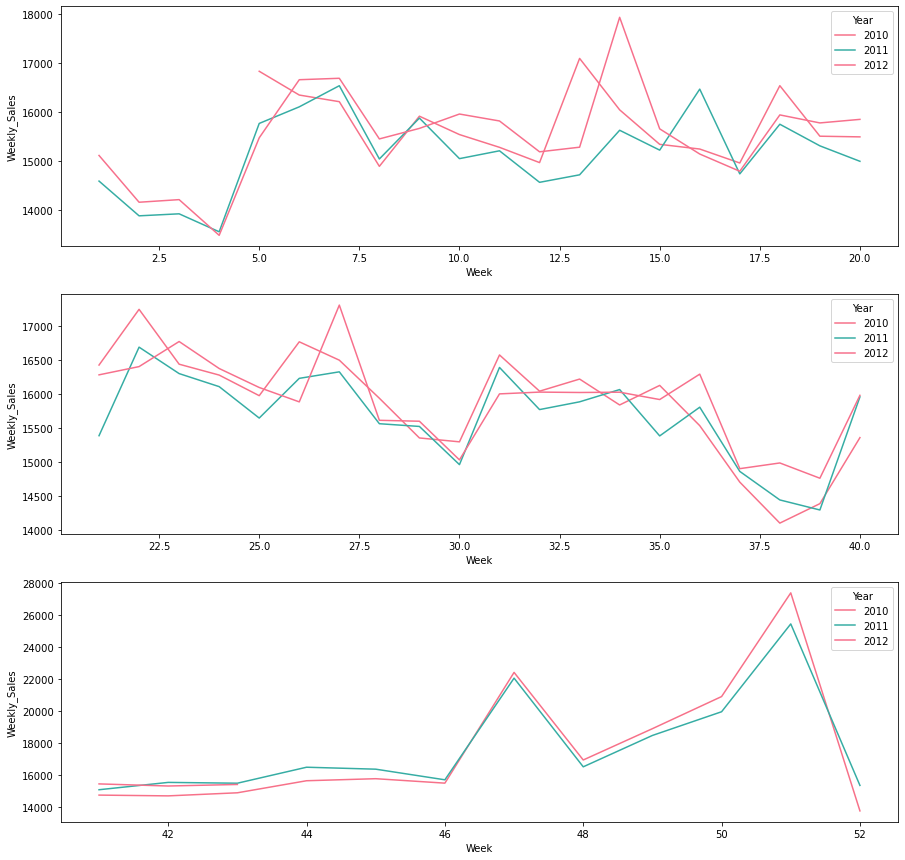

In [43]:
# 週番号による違いを見るため、年、週を追加
train_eda['Week'] = train_eda['Date'].dt.week
train_eda['Year'] = train_eda['Date'].dt.year
fig, ax = plt.subplots(3, 1, figsize=(15,15))
sns.lineplot(x='Week', y='Weekly_Sales', 
             data=train_eda[(train_eda['Week']>0)&(train_eda['Week']<=20)], 
             hue='Year',palette='husl',ci=None,ax=ax[0])
sns.lineplot(x='Week', y='Weekly_Sales', 
             data=train_eda[(train_eda['Week']>20)&(train_eda['Week']<=40)], 
             hue='Year',palette='husl',ci=None,ax=ax[1])
sns.lineplot(x='Week', y='Weekly_Sales', 
             data=train_eda[(train_eda['Week']>40)&(train_eda['Week']<=60)], 
             hue='Year',palette='husl',ci=None,ax=ax[2])

* 週毎では、47週（Thanksgiving）、51週（Christmas前週）に増加がある
* 年ごとの比較では、13〜16週付近の多少のバラツキがあるものの、それ以外はほぼ同じ傾向で推移している

#### 売上の分布を確認

<AxesSubplot:xlabel='Weekly_Sales', ylabel='Density'>

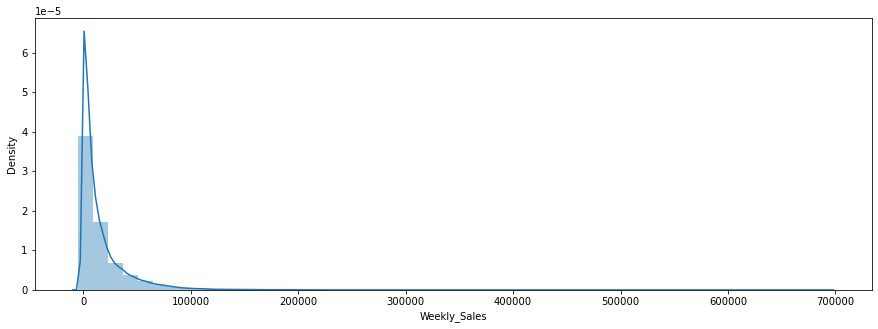

In [44]:
plt.figure(figsize=(15,5))
sns.distplot(train_eda['Weekly_Sales'])

* 大きく左に寄っており、売上が100000以上のサンプルは全体から見ると極僅かであることが分かる

#### Dept毎の差を詳しく確認

全Dept（81）から1〜10のみ抜粋

<AxesSubplot:xlabel='Date', ylabel='Weekly_Sales'>

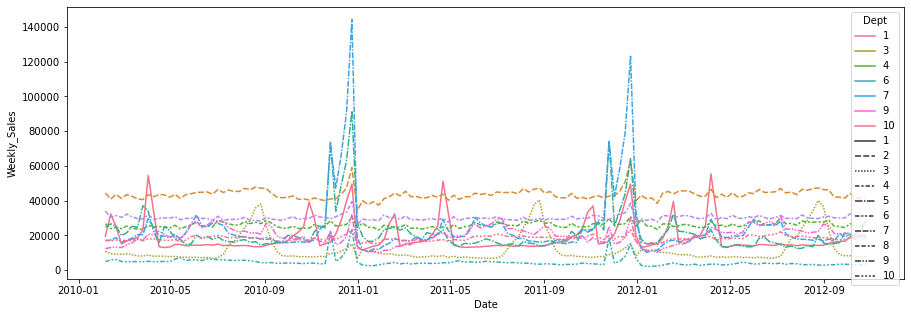

In [45]:
plt.figure(figsize=(15,5))
sns.lineplot(x='Date', y='Weekly_Sales', data=train_eda[train_eda['Dept'] <= 10],
             hue='Dept', style='Dept',palette='husl',ci=None)

* Deptごとに見ると全体傾向とは異なるものが存在する

#### faetureデータの各項目の推移を確認

<AxesSubplot:xlabel='Date', ylabel='Unemployment'>

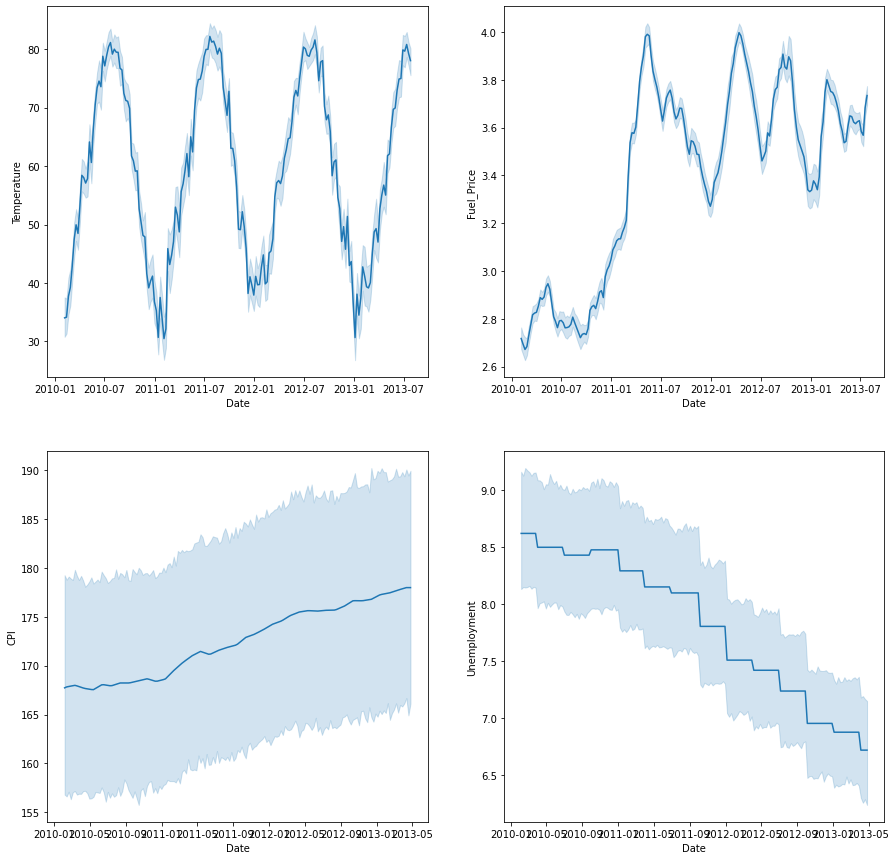

In [46]:
fig, ax = plt.subplots(2, 2, figsize=(15,15))
sns.lineplot(x='Date', y='Temperature', data=features, ax=ax[0][0])
sns.lineplot(x='Date', y='Fuel_Price', data=features, ax=ax[0][1])
sns.lineplot(x='Date', y='CPI', data=features, ax=ax[1][0])
sns.lineplot(x='Date', y='Unemployment', data=features, ax=ax[1][1])

* Temperatureは（当然ながら）年間で周期がある
* Fuel_Priceは2011年初頭に増加した後、増減を繰り返している
* CPIは増加、Unenploymentは減少傾向

#### 変数間の相関関係を確認

<AxesSubplot:>

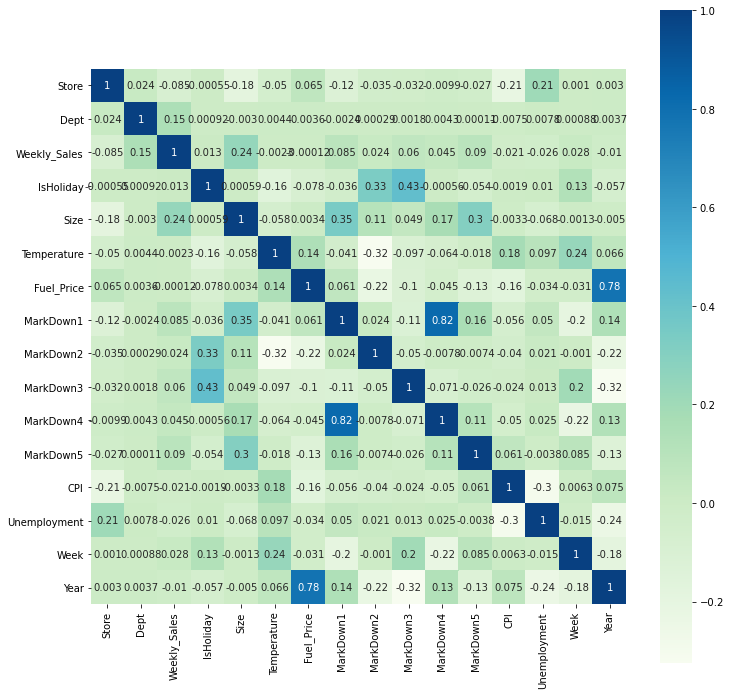

In [47]:
plt.figure(figsize=(12,12))
sns.heatmap(train_eda.corr(), cmap='GnBu', square=True, annot=True)

* MarkDown1とMarkDown4に高い相関
* MarkDown1,5とSizeに中程度の相関
* Markdonw2,3とIsHolidayに中程度の相関
* SizeとWeekly_Salesに僅かな相関
* YearとFuel_Priceに高い相関
* 上記以外には目立つ相関は見られない

---

## 2. Model Building

モデル構築は以下のアプローチで実施した。各ステップでの詳細は後述する。
- **使用するアルゴリズムの選定**  
    回帰分析の際に一般的に使用される8種類のアルゴリズムをデフォルトパラメータ、全特徴量を使用した状態で試し、スコアの良かったものを選択した。
    選択したモデルに対し、特徴量作成と選択、パラメータチューニングを繰り返し実施しながら、一番良いスコアとなるものを最終モデルとした。  

- **特徴量作成**  
Tree系のモデルによるfeature importanceを元にし、変数の組み合わせや値の置換方法などを変えて繰り返しTrainingを行った。

- **パラメータチューニング**  
各アルゴリズムのデフォルトパラメータを元にし、絞り込みながら繰り返しTrainingを行い最もValidationデータでのスコアが良くなるパラメータの組み合わせを選定した。

- **データの分割**  
対象は時系列データであり、Cross validationは使用できないため、単純な分割でTrainデータとValidationデータを作成する。データ分割処理は関数として定義しておき、TrainデータとValidationデータの分割割合による違いを確認する際に再利用できるようにした。分割の際には、単純にデータ全体を分割するのではなく、時系列データであることを考慮して分割比率の閾値にあたる日付をもとに分割している。

- **評価指標**  
評価指標は[公式ページ](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/overview/evaluation)で指示されている通り、下記の数式に基づいたWeighted Mean Abusolute Errorを使用する。Weight部分はデータ内の'IsHoliday'カラムを参照する必要があるため、独自で定義した関数を使用した。Weightは対象の週がHolidayの場合に5、それ以外の場合には1が割り当てられるため、Holidayのエラーに対してより厳しく評価ことになる。  
モデルのトレーニング時には、カスタム評価指標が使えない場合や学習速度が遅くなる場合があるため、予め用意されている"mae"または"mse"を使用している。また予測値の確認と評価のため、正解値と予測値のグラフ描画関数も用意した。

$$
WMAE = \frac{1}{\sum w_i} \sum_{i=1}^{n} {w_i}|y_i- \hat{y_i}|
$$

- **最終モデルとアンサンブル**  
    作成したモデルの予測値、およびSimple Average Emsembleによる予測値をkaggleにsubmitし、Privateスコア、Publicスコアを確認して最終スコアを決定した。

In [48]:
def wmae(df, pred):
    ''' Return Weighted Mean Abusolute Error'''
    df['Weight'] = df.apply(lambda x: 5 if x.IsHoliday == 1 else 1, axis=1)
    total_weight = sum(df['Weight'])
    total = sum(df['Weight'] * abs((df['Weekly_Sales'] - pred)))
    
    return total / total_weight

In [49]:
def plotResult(df, y_pred):
    ''' Display graph wich y and y_pred'''
    # legendほしい
    sns.lineplot(x='Date', y='Weekly_Sales', ci=None, data=df, legend='auto')
    sns.lineplot(x=df['Date'], y=y_pred, ci=None, legend='auto')

In [50]:
# 分割用の日付を取得
def getThresholdDate(date_list, size):
    '''Return a threshold date'''
    n = len(date_list)
    return date_list[int((1-size)*n-1)]

In [51]:
# 取得した日付を元にデータをtrainとvalidに分割する
def splitData(df, test_size):
    '''Split data based on the threshold date'''
    date = getThresholdDate(df['Date'].drop_duplicates(), test_size)
    
    train = df[df['Date'] <= date]
    train_x = train.drop(['Date','Weekly_Sales'],axis=1)
    train_y = train['Weekly_Sales']

    valid = df[df['Date'] > date]
    valid_x = valid.drop(['Date','Weekly_Sales'],axis=1)
    valid_y = valid['Weekly_Sales']

    return train, train_x, train_y, valid, valid_x, valid_y

### 2.1 各アルゴリズムの初期評価

In [52]:
train_merged.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
Type                    object
Size                     int64
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
dtype: object

#### 仮特徴量の作成

アルゴリズム選定のための仮の特徴量を作成する。

In [53]:
# Typeをダミー変数にする
type_dummies = pd.get_dummies(train_merged['Type'], prefix='type')
train_trial = pd.concat([train_merged,type_dummies],axis=1)
train_trial = train_trial.drop(['Type'], axis=1)

# 年、月データを付与
train_trial['Year'] = train_trial['Date'].dt.year
train_trial['Month'] = train_trial['Date'].dt.month
train_trial['Week'] = train_trial['Date'].dt.week

# NaN値(Markdown1-5)を0で置換する
train_trial = train_trial.fillna(0)

In [54]:
# 0.8-0.2の割合でTrain、Validデータに分割する
train, train_x, train_y, valid, valid_x, valid_y = splitData(train_trial, 0.2)

In [55]:
# Lasso, Ridge, KNeighborsのために標準化したtrain,validデータも準備する
scaler = StandardScaler().fit(train_x)
train_x_scaled = scaler.transform(train_x)
valid_x_scaled = scaler.transform(valid_x)

print(train_x.shape, train_x_scaled.shape, train_y.shape)
print(valid_x.shape, valid_x_scaled.shape, valid_y.shape)

(335761, 19) (335761, 19) (335761,)
(85809, 19) (85809, 19) (85809,)


#### 各アルゴリズムでのスコアを確認

回帰分析で代表的な以下の8種類を候補として、デフォルトパラメータでスコアを取得し比較した。今回は対象データの加工やトレーニング工程を効率化するため、機械学習手法のみを対象とし、統計的手法（ARMA,ARIMA）、ニューラルネットワークは対象外とした。
* LinearRegression
* Lasso
* Ridge
* KNeighborRegressor
* DecisionTreeRegressor
* RandomForestRegressor
* LightGBM
* Xgboost

In [56]:
scores = pd.DataFrame(columns=['Score'])

In [57]:
trial_lr = LinearRegression().fit(train_x, train_y)
scores.loc['LinearRegression'] = wmae(valid,trial_lr.predict(valid_x))

In [58]:
trial_lasso = Lasso().fit(train_x_scaled, train_y)
scores.loc['Lasso'] = wmae(valid,trial_lasso.predict(valid_x_scaled))

In [59]:
trial_ridge = Ridge().fit(train_x_scaled, train_y)
scores.loc['Ridge'] = wmae(valid,trial_ridge.predict(valid_x_scaled))

In [60]:
trial_knn= KNeighborsRegressor().fit(train_x_scaled, train_y)
scores.loc['KNeighborsRegressor'] = wmae(valid,trial_knn.predict(valid_x))

In [61]:
trial_dt = DecisionTreeRegressor().fit(train_x, train_y)
scores.loc['DecisionTree'] = wmae(valid,trial_dt.predict(valid_x))

In [62]:
trial_rf = RandomForestRegressor().fit(train_x, train_y)
scores.loc['RandomForest'] = wmae(valid,trial_rf.predict(valid_x))

In [63]:
trial_lgb = lgb.LGBMRegressor().fit(train_x, train_y)
scores.loc['LightGBM'] = wmae(valid,trial_lgb.predict(valid_x))

In [64]:
trial_xgb = xgb.XGBRegressor().fit(train_x, train_y)
scores.loc['Xgboost'] = wmae(valid,trial_xgb.predict(valid_x))

In [65]:
scores

,Score
LinearRegression,14627.696044
Lasso,14627.720943
Ridge,14627.695237
KNeighborsRegressor,30428.391169
DecisionTree,2541.376067
RandomForest,1891.994658
LightGBM,4207.252024
Xgboost,3403.178689


* Tree系の４つのスコアが良い結果となった。この結果に基づき、DecisionTree, RandomForest, LightGBM, Xgboostを採用することとする

#### Feature Importancesの確認

特徴量作成の参考とするため、Tree系のfeature importanceを確認する

In [66]:
importance = pd.DataFrame({'Feature':train_x.columns.values,
                           'DecisionTree':trial_dt.feature_importances_,
                           'RandomForest':trial_rf.feature_importances_,
                           'LightGBM':trial_lgb.feature_importances_,
                           'Xgboost':trial_xgb.feature_importances_})

# LightGBMのみスケールが異なるため修正する
importance['LightGBM'] = importance['LightGBM']/sum(importance['LightGBM'])

# 暫定スコアが一番良かったRandomForestを基準にソートする
importance.sort_values(by=['RandomForest'], ascending=False)

,Feature,DecisionTree,RandomForest,LightGBM,Xgboost
1,Dept,0.607269,0.619020,0.569333,0.210674
3,Size,0.205728,0.192362,0.107333,0.209015
0,Store,0.051207,0.052388,0.103333,0.063523
18,Week,0.055251,0.045098,0.067333,0.046989
11,CPI,0.028385,0.028717,0.041333,0.047770
12,Unemployment,0.011483,0.012379,0.023667,0.017035
4,Temperature,0.010844,0.011273,0.015333,0.010561
14,type_B,0.011443,0.010656,0.013333,0.217771
17,Month,0.001868,0.006677,0.018667,0.021371
8,MarkDown3,0.002212,0.005952,0.010333,0.060948


* 上位4位までは、Xgboostのいくつかの例外（'type_B','MarkDown3'など）を除くと概ね共通している。
* 特に'Month'以下は多くの変数が0.01以下を下回っている。

### 2.2 特徴量エンジニアリング

2.1の結果を参考に、特徴量を選定する

#### **特徴量の選定プロセス詳細**  
重要度が0.05以上となった'Dept','Size','Store','Week'を基準として、それ以外の特徴量を増減させながらスコアの変化を観察し、最終的に使用する特徴量を決定した。なお'IsHoliday'に関しては、評価関数でも使用されておりこの課題において特別な意味を持つことから、除外せずに特徴量として使用した。  

**MarkDown1-5**: 匿名の数値とされており、単位や基準が明確でないことから、以下の３パターンを試した。  
(a) 使用しない  
(b) NaN値を0に置換、それ以外はそのまま使用  
(c) NaN値:0、値あり:1　に置換  

**IsHoliday**: kaggleサイトに各祝日の詳細が明記されていることから、以下の３パターンを試した。  
(a) そのまま使用する  
(b) 日付によって'Super Bown','Labor Day','Thanksgiving','Christmas','None'(非祝日)のラベルをつけ、カテゴリ変数として扱う  
(c) EDAの結果およびkernelを参考にし、Christmasの前週(51週)に売上が増加する傾向が見られることから、bに追加して、Christmasを示すフラグを52週ではなく51週に付け替える

**type_A,type_B,type_C,Temperature,Fuel_Price,CPI,Unemployment,Year,Month**: 追加することによりスコアが向上するかどうかを１つ１つ確認し、増加した場合は採用、そうでない場合は不採用とした。

**Weekly_Sales**: ヒストグラムから分かるとおり、大きく左に偏ったデータ分布であることから、上位5％を外れ値とみなして除外する試みも行った。通常外れ値はIQRを元に除外するが、今回は除外対象件数が非常に多くなったことから、手動で件数を確認し5%で試すこととした。さらにWeekly_Salesに含まれるマイナス値は特にkaggleサイトでも言及されておらず、どのような状態により発生したデータか不明であるため、そのままのパターンと除外するパターンを試した。  
(a) そのまま使用する  
(b) マイナス値を除去  
(c) マイナス値＋上側5%外れ値除去

#### 特徴量作成処理

特徴量をtrainデータとtestデータに同じように作成するため、特徴量作成プロセスは関数としてまとめた。最終的に使用しないこととした変数に関する特徴量作成のコードは末尾の[Appendix](#Appendix)に記載。

#### **試した組み合わせ** 
1. Weekly_Sales, Store, Dept, Size, Week, IsHoliday
2. Weekly_Sales **(b)**, Store, Dept, Size, Week, IsHoliday
3. Weekly_Sales **(c)**, Store, Dept, Size, Week, IsHoliday
4. Weekly_Sales, Store, Dept, Size, Week, IsHoliday, CPI
5. Weekly_Sales, Store, Dept, Size, Week, IsHoliday, Unemployment
6. Weekly_Sales, Store, Dept, Size, Week, IsHoliday, Temperature
7. Weekly_Sales, Store, Dept, Size, Week, IsHoliday, type_A, type_B, type_C
8. Weekly_Sales, Store, Dept, Size, Week, IsHoliday_Christmas **(c)**, IsHoliday_Labor Day, IsHoliday_Super Bowl, IsHoliday_Thanksgiving
9. Weekly_Sales, Store, Dept, Size, Week, IsHoliday_Christmas **(c)**, IsHoliday_Labor Day, IsHoliday_Super Bowl, IsHoliday_Thanksgiving
10. Weekly_Sales, Store, Dept, Size, Week, IsHoliday, MarkDown1-5 **(b)**
11. Weekly_Sales, Store, Dept, Size, Week, IsHoliday, MarkDown1-5 **(c)**
12. Weekly_Sales, Store, Dept, Size, Week, IsHoliday, Year
13. Weekly_Sales, Store, Dept, Size, Week, IsHoliday, Month
14. Weekly_Sales, Store, Dept, Size, Week, IsHoliday, Year, Month


#### **最終的に採用した特徴量**  
パラメータなどの特徴量以外の条件を固定し、パターン1のスコアを基準として探索した結果、最もスコアが良かった組み合わせは **パターン12** であった。
* マイナス値の除去ではスコアが僅かに悪化、外れ値の除去ではValidスコアは大幅に向上したがOverfittingが発生しTestデータでのスコアは大幅に悪化した。（パターン2,3）
* CPIやUnemploymentなどの項目追加ではスコアの改善は見られなかった。（パターン4,5,6,7）
* IsHolidayの分割、Chrismasのフラグ付け替えも大きなスコア改善効果はなかった。（パターン8,9）
* MarkDownはb,cに大きな違いは見られず、またスコアも僅かに悪化しただけだった。（パターン10,11）
* Year,Monthの追加は特にDecisionTreeとRandomForestで大きなスコアの改善が見られた。中でもYearを単独で追加したパターンが最も上昇幅が大きかった。（パターン12,13,14）

In [67]:
def featureCreation(df, mode='train'):
    '''Return features'''
    df = df.copy()
    
    # 年、週データを付与
    df['Year'] = df['Date'].dt.year
    df['Week'] = df['Date'].dt.week

    df = df.drop(['Type','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','Temperature','Fuel_Price','CPI','Unemployment'], axis=1)

    return df

In [68]:
train_merged.shape

(421570, 16)

In [69]:
train_modified = featureCreation(train_merged)
train_modified.shape
train_modified.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
Size                     int64
Year                     int64
Week                     int64
dtype: object

In [70]:
train, train_x, train_y, valid, valid_x, valid_y = splitData(train_modified, 0.20)
train_x.shape

(335761, 6)

### 2.3 パラメータチューニング

時系列データのためGridSearchCVなどのCross Validationは使わず(未来データを含んだ評価となってしまうため）、trainとvalidに2分割したデータでパラメータの組み合わせのみ探索した。
探索用の関数は以下とおり定義した。

In [71]:
def paramSearch(params_combo, estimator, train_x, train_y, valid_x, valid_y, fit_params=None):
    # Validation結果格納用リスト、進捗表示用変数を初期化
    validation_wmae = []
    count = 1
    
    # KeyとParameter候補の組み合わせで、dictionaryを作成
    keys, values = zip(*params_combo.items())
    all_combo = list(itertools.product(*values))
    for value_combo in all_combo:
        params_combo_dic = dict(zip(keys, value_combo))
    
        # 進捗をprint
        print("%s / %s"%(count, len(all_combo)))
        print(params_combo_dic)
        count += 1
    
        model = estimator.set_params(**params_combo_dic)
        
        # Fittingの際のパラメータがある場合のみ設定する
        if fit_params == None:
            model.fit(train_x, train_y)
        else:
            model.fit(train_x, train_y, **fit_params)
        
        y_pred = model.predict(valid_x)
        score = wmae(valid, y_pred)
        print("score:", score)
        validation_wmae.append(score)
        print("best :",np.argmin(validation_wmae)+1)
        
    # 最もスコアの良かったパラメータの組み合わせを抽出して表示
    best_param_combo = all_combo[np.argmin(validation_wmae)]
    print ("best_params:", best_param_combo)
    print ("best_score :", np.min(validation_wmae))
    
    return best_param_combo

#### Decision Tree

In [72]:
# Parameter Combo for DecisionTree
params_dt = {"min_samples_split":[2], #[2,3,4],
         "min_samples_leaf":[2], #[2,3,4],
         "ccp_alpha":[3]} #[0,1,2,3,4,5,6]}

In [73]:
best_params_dt = paramSearch(params_dt, DecisionTreeRegressor(), train_x, train_y, valid_x, valid_y)

1 / 1
{'min_samples_split': 2, 'min_samples_leaf': 2, 'ccp_alpha': 3}
score: 1705.9952237047967
best : 1
best_params: (2, 2, 3)
best_score : 1705.9952237047967


#### Random Forest

In [74]:
# Parameter Combo for RandomForest
params_rf = {'n_estimators': [720], #range(700,801,20) #range(700,1001,100), #[100,500,1000],
            'max_features': [4], #range(1,11), #[5,10,20] 
            'min_samples_split': [6], #range(4,9) #[1,5,10]
            'min_samples_leaf': [3], #[2,3,4,5,6]
            'n_jobs': [-1]}

In [75]:
best_params_rf = paramSearch(params_rf, RandomForestRegressor(), train_x, train_y, valid_x, valid_y)

1 / 1
{'n_estimators': 720, 'max_features': 4, 'min_samples_split': 6, 'min_samples_leaf': 3, 'n_jobs': -1}
score: 1612.276209847435
best : 1
best_params: (720, 4, 6, 3, -1)
best_score : 1612.276209847435


#### LightGBM

In [76]:
# Parameter Combo for LightGBM
params_lgb = {'learning_rate': [0.1], #0.3 0.5
             'n_estimators': [140], #[135,140,145,150]#[500, 2000, 10000] #[500] #[100,200,500]
             'num_leaves': [1250], #[1225,1250,1275] #[8000,9000,10000,11000,12000] #[100,250,500] #[50,100]
             'max_depth': [35], #[31,32,33,34,35,36,37] #[10,30,50,100,150]
             'min_data_in_leaf': [7]} #[6,7,8]
fit_params_lgb = {'eval_metric':'mae',
                 'eval_set':[(valid_x,valid_y)],
                 'early_stopping_rounds':10,
                 'verbose':False}

In [77]:
best_params_lgb = paramSearch(params_lgb,
                              lgb.LGBMRegressor(),
                              train_x, train_y, valid_x, valid_y, fit_params_lgb)

1 / 1
{'learning_rate': 0.1, 'n_estimators': 140, 'num_leaves': 1250, 'max_depth': 35, 'min_data_in_leaf': 7}
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
score: 2036.9871395911446
best : 1
best_params: (0.1, 140, 1250, 35, 7)
best_score : 2036.9871395911446


#### Xgboost

In [78]:
# Parameter Combo for Xgboost
params_xgb = {'learning_rate': [0.1], #[0.01, 0.1, 0.3, 0.5]
             'n_estimators': [500], #range(400,500,600) #[100,200,500,1000]
             'max_depth': [18], #[17,18,19] #range(10,21,2) #range(10,51,10)#[10,30,50,100,150]
             'min_child_weight': [7]}  #range(1,10,2)
fit_params_xgb = {'eval_metric':'mae',
                 'eval_set':[(valid_x,valid_y)],
                 'early_stopping_rounds':10,
                 'verbose':False}

In [79]:
best_params_xgb = paramSearch(params_xgb,
                              xgb.XGBRegressor(),
                              train_x, train_y, valid_x, valid_y, fit_params_xgb)

1 / 1
{'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 18, 'min_child_weight': 7}
score: 1652.403331309368
best : 1
best_params: (0.1, 500, 18, 7)
best_score : 1652.403331309368


#### 最もスコアの良かったパラメータでモデルを作成

1705.9952237047967


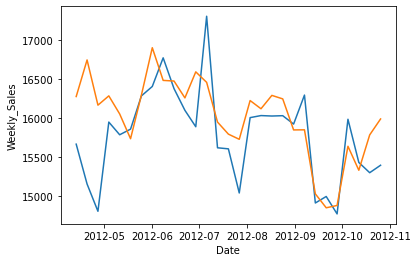

In [80]:
model_dt = DecisionTreeRegressor(min_samples_split=best_params_dt[0],
                                 min_samples_leaf=best_params_dt[1],
                                 ccp_alpha=best_params_dt[2])
model_dt.fit(train_x, train_y)
y_pred_dt = model_dt.predict(valid_x)
plotResult(valid, y_pred_dt)
print(wmae(valid, y_pred_dt))

1609.9282110987901


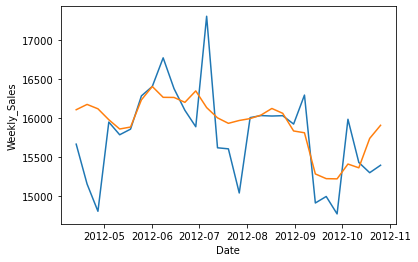

In [81]:
model_rf = RandomForestRegressor(n_estimators=best_params_rf[0],
                                 max_features=best_params_rf[1],
                                 min_samples_split=best_params_rf[2],
                                 min_samples_leaf=best_params_rf[3],
                                 n_jobs=-1)
model_rf.fit(train_x, train_y)
y_pred_rf = model_rf.predict(valid_x)
plotResult(valid, y_pred_rf)
print(wmae(valid, y_pred_rf))

[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
2000.216665680703


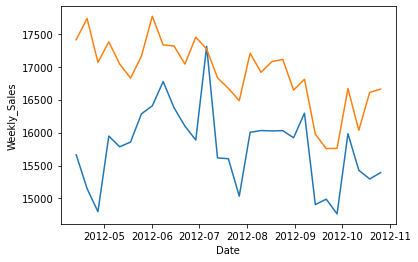

In [82]:
model_lgb = lgb.LGBMRegressor(learning_rate=best_params_lgb[0],
                              n_estimators=best_params_lgb[1],
                              num_leaves=best_params_lgb[2],
                              max_depth=best_params_lgb[3],
                              min_data_in_leaf=best_params_lgb[4],
                              n_jobs=-1)
model_lgb.fit(train_x, train_y)
y_pred_lgb = model_lgb.predict(valid_x)
plotResult(valid, y_pred_lgb)
print(wmae(valid, y_pred_lgb))

1968.0662494933576


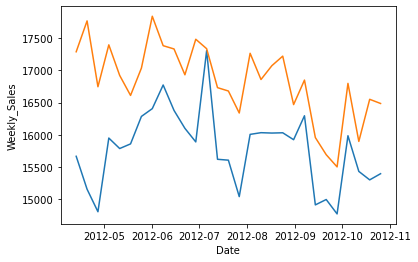

In [83]:
model_xgb = xgb.XGBRegressor(learning_rate=best_params_xgb[0],
                             n_estimators=best_params_xgb[1],
                             max_depth=best_params_xgb[2],
                             min_child_weight=best_params_xgb[3])
model_xgb.fit(train_x, train_y)
y_pred_xgb = model_xgb.predict(valid_x)
plotResult(valid, y_pred_xgb)
print(wmae(valid, y_pred_xgb))

* Tuning後のパラメータでは全てのアルゴリズムで2.1で得たスコアを上回った。特にDecisionTreeとRandomForestが良い結果となっている。
* グラフで実際の値との比較を見てみると、RandomForestは比較的なだらかな形になっているのに対し、その他の3種は鋭角なグラフで似た形となっている。
* LightGBM,Xgboostは予測値が全体的に上振れしている。

### 2.4 Train-Validの分割比率

Trainデータとvalidデータの分割割合がスコアに与える影響についても調査を行った。先述したsplitData関数を用い、他の要素（特徴量とパラメータ）を固定した上で、以下の組み合わせを試した。
特徴量選定とパラメータチューニング時は0.80-0.20で固定して行っている。
* 0.60 - 0.40
* 0.70 - 0.30
* 0.80 - 0.20
* 0.90 - 0.10
* 1.00 - 0.00

trainデータ100%、validデータなしの場合は検証ができないが、代わりとしてtrainingしたモデルで予測値を作成しSubmitしてtestデータでのスコアを確認した。単純にtrainデータが増えた分だけ、validデータでのスコア、testデータでのスコアが良くなることが確認でき、trainデータを増やすことによるOverfittingなどは見受けられなかった。

### 2.5 Testデータでの評価

今回はkaggleコンペティションを題材としており、testセットの評価結果を得ることができる。コンペ同様に、testセットのスコアも参考にしながら特徴量やパラメータの改善を行った。

下記はtestデータでの予測値作成とsubmissionファイル作成のコードである。

In [84]:
test_modified = featureCreation(test_merged, 'test')
test_modified = test_modified.drop(['Date'], axis=1)
test_modified.dtypes

Store        int64
Dept         int64
IsHoliday     bool
Size         int64
Year         int64
Week         int64
dtype: object

In [85]:
def createPredictions(models, data):
    '''Return a list of predicted values'''
    prediction = pd.DataFrame()
    for key, model in models.items():
        prediction[key] = model.predict(data)
    return prediction

In [86]:
def createSubmissionFiles(prediction):
    '''Create and save submission files'''
    for method_name in prediction.columns:
        submission = pd.DataFrame({"Id":test_merged['Store'].astype(str)+'_'+
                                        test_merged['Dept'].astype(str)+'_'+
                                        test_merged['Date'].astype(str),
                                  "Weekly_Sales":prediction[method_name]})
        submission.to_csv('submission_%s.csv'%method_name, index=False)

In [87]:
models = {'dt':model_dt,
         'rf':model_rf,
         'lgb':model_lgb,
         'xgb':model_xgb}
predictions = createPredictions(models, test_modified)
predictions['ave'] = predictions.mean(axis=1)
createSubmissionFiles(predictions)

### 2.6 結果と最終モデル

2.2 - 2.5を繰り返し実施しながら最適な特徴量、パラメータ、train-validデータの割合の組み合わせを探索した。下記がその結果である。

**特徴量**:  
Weekly_Sales, Store, Dept, Size, Week, IsHoliday, Year

**パラメータ**:  
DecisionTree - (2, 2, 3)  
RandomForest - (720, 4, 6, 3)  
LightGBM     - (0.1, 140, 1250, 35, 7)  
Xgboost      - (0.1, 500, 18, 7)  

**Train-Valid分割**:  
trainデータが増えるにつれ、validデータでの評価スコアは良くなった。またtrain80%とtrain100%でそれぞれ学習したモデルのtestデータに対する予測値を比較すると、全てのアルゴリズムでtrain100%のモデルの予測値のほうがスコアが良かった。  
時系列データは直近データを使った予測のほうが一般的に予測精度が高くなるため、最終予測値にはtrainデータの全量を使用して学習したモデルが最適であるという結論に至った。(trainデータ全量を使う是非については、参考資料に挙げたスレッド "forum: Do you re-train on the whole dataset after validating the model?"を参考にした)

---

## 3. Final Output & Score

Decision Tree, Random Forest, LightGBM, Xgboostのそれぞれの結果からsubmissionファイルを作成し、kaggleへSubmitする。

### 3.1 最終予測値の出力とモデルの保存

前述のとおり、データはtrainデータを全量使用し、Section 2で求めた特徴量、パラメータを用いて再度fittingを行う。また学習済みの各アルゴリズムのモデルをpickle形式で出力する。

In [88]:
# trainデータ全量を使用して学習する(testデータサイズに0を指定)
train, train_x, train_y, valid, valid_x, valid_y = splitData(train_modified, 0.0)
print(train.shape,valid.shape)

(421570, 8) (0, 8)


In [89]:
# ファイル名に使用する現在時刻を取得
now = datetime.now().strftime('%Y%m%d-%H%M%S')

In [90]:
model_dt_all = DecisionTreeRegressor(min_samples_split=2,
                                     min_samples_leaf=2,
                                     ccp_alpha=3)
model_dt_all.fit(train_x, train_y)
pickle.dump(model_dt_all, open("model_dt_all_%s.pickle"%now,"wb"))

In [91]:
model_rf_all = RandomForestRegressor(n_estimators=720,
                                     max_features=4,
                                     min_samples_split=6,
                                     min_samples_leaf=3,
                                     n_jobs=-1)
model_rf_all.fit(train_x, train_y)
pickle.dump(model_rf_all, open("model_rf_all_%s.pickle"%now,"wb"))

In [92]:
model_lgb_all = lgb.LGBMRegressor(learning_rate=0.1,
                                  n_estimators=140,
                                  num_leaves=1250,
                                  max_depth=35,
                                  min_data_in_leaf=7,
                                  n_jobs=-1)
model_lgb_all.fit(train_x, train_y)
pickle.dump(model_lgb_all, open("model_lgb_all_%s.pickle"%now,"wb"))

[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


In [93]:
model_xgb_all = xgb.XGBRegressor(learning_rate=0.1,
                                 n_estimators=500,
                                 max_depth=18,
                                 min_child_weight=7)
model_xgb_all.fit(train_x, train_y)
pickle.dump(model_xgb_all, open("model_xgb_all_%s.pickle"%now,"wb"))

In [94]:
models = {'dt':model_dt_all,
         'rf':model_rf_all,
         'lgb':model_lgb_all,
         'xgb':model_xgb_all}
predictions = createPredictions(models, test_modified)
predictions['ave'] = predictions.mean(axis=1)
createSubmissionFiles(predictions)

### 3.2 スコアの確認

#### 作成したファイルのSubmit

In [95]:
!kaggle competitions submit -c walmart-recruiting-store-sales-forecasting -f submission_dt.csv -m "Decision Tree"

100%|██████████████████████████████████████| 3.50M/3.50M [00:02<00:00, 1.29MB/s]
Successfully submitted to Walmart Recruiting - Store Sales Forecasting

In [96]:
!kaggle competitions submit -c walmart-recruiting-store-sales-forecasting -f submission_rf.csv -m "Random Forest"

100%|██████████████████████████████████████| 3.84M/3.84M [00:02<00:00, 1.56MB/s]
Successfully submitted to Walmart Recruiting - Store Sales Forecasting

In [97]:
!kaggle competitions submit -c walmart-recruiting-store-sales-forecasting -f submission_lgb.csv -m "LightGBM"

100%|██████████████████████████████████████| 3.85M/3.85M [00:02<00:00, 1.53MB/s]
Successfully submitted to Walmart Recruiting - Store Sales Forecasting

In [98]:
!kaggle competitions submit -c walmart-recruiting-store-sales-forecasting -f submission_xgb.csv -m "Xgboost"

100%|██████████████████████████████████████| 2.89M/2.89M [00:02<00:00, 1.03MB/s]
Successfully submitted to Walmart Recruiting - Store Sales Forecasting

In [99]:
!kaggle competitions submit -c walmart-recruiting-store-sales-forecasting -f submission_ave.csv -m "Average of four methods"

100%|██████████████████████████████████████| 3.84M/3.84M [00:02<00:00, 1.71MB/s]
Successfully submitted to Walmart Recruiting - Store Sales Forecasting

#### kaggle submissionページのスクリーンショット

<img src="scores.png">

---

## 4. Conclusion

最終スコアは最も良かったSimple Average Ensembleによる予測値を採用した。
* Private: 2834.65812
* Public: 2747.29079  

公開されているPrivate Leaderboardでは、Gold:2301-2535、Siver:2541-2798、Bronze:2801-2914となっており、まずまずのスコアとなった。

### 4.1 考察

* アルゴリズム選定の面では、初期評価の段階でTree系のアルゴリズムはある程度の精度が出ていたのに対し、それ以外の手法では5桁のスコアとなり、ハッキリと違いが出た点が興味深かった。最終結果を見ると、僅かな差ではあるがBoostingを使用しているXgboost、LightGBMの２つが他２つよりも良いスコアとなり昨今のトレンドとも一致した。
* 特徴量エンジニアリングの面では、最終的に選択された特徴量は6種類、feature.csvで提供された項目の使用なし、という比較的シンプルなモデルとなった。また重要度では最も低かった’Year'がスコアに貢献したという点では、EDAや選定プロセスにおいて、特徴量がモデルに及ぼす影響を１つ１つ丁寧に見ていくことが大切であるということが改めて分かった。
* パラメータチューニング、学習の面では、対象アルゴリズムを4つとしたため学習自体には時間を要したが、チューニング・学習のコードを共通化したことで効率的に実施できた。

### 4.2 課題と改善点

今回は選定した4つのアルゴリズムを限られた時間で効率的にチューニング・学習することに重点をおいたため、同じ特徴量を使うことを前提としている。それぞれのアルゴリズムに対し個別に特徴量の選定を行うことができれば、個々のモデルのスコアを改善できる可能性がある。特にLightGBM、XgboostはDecesionTree、RandomForestと比べて特徴量の重要度が違っていたり、validデータでの評価スコアが他2つよりも高いなど、異なる特徴が見られるため更にチューニングできる可能性が高い。  
使用するアルゴリズムの観点では、他に(1)Neural NetworkやARIMAモデルなど機械学習以外の手法を取り入れる、(2)加重平均やStackingなどのアンサンブルを試す、ことが考えられる。単純な平均でも単体モデルに比べて100〜200ポイント近く改善しており、他のアンサンブル手法も試す価値があると言える。

---

## Appendix

In [100]:
def featureCreation_not_used(df, mode='train'):
    df = df.copy()
    # Typeをダミー変数にする
    type_dummies = pd.get_dummies(df['Type'], prefix='type')
    df = pd.concat([df,type_dummies],axis=1)
    df = df.drop(['Type'], axis=1)
    
    # 年、月データを付与(週はEDAパートで作成済)
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.week
    
    # MarkDownの処理
    df['MarkDown1'] = df.apply(lambda x: 1 if x.MarkDown1 > 0 else 0, axis=1)
    df['MarkDown2'] = df.apply(lambda x: 1 if x.MarkDown2 > 0 else 0, axis=1)
    df['MarkDown3'] = df.apply(lambda x: 1 if x.MarkDown3 > 0 else 0, axis=1)
    df['MarkDown4'] = df.apply(lambda x: 1 if x.MarkDown4 > 0 else 0, axis=1)
    df['MarkDown5'] = df.apply(lambda x: 1 if x.MarkDown5 > 0 else 0, axis=1)
        
    # IsHolidayの処理
    # [Pattern:b] IsHolidayを日付に基づいて変換
    df['IsHoliday'] = df['Date'].apply(checkHoliday)
    holiday_dummies = pd.get_dummies(df['IsHoliday'], prefix='IsHoliday')
    df = pd.concat([df,holiday_dummies],axis=1)
    df = df.drop(['IsHoliday','IsHoliday_None'], axis=1)
    
    # [Pattern:c] Christmasの前週に売上が増加するためフラグをつけ直す
    df['IsHoliday'] = df.apply(lambda x: True if x.Week == 51 else x.IsHoliday,axis=1)
    df['IsHoliday'] = df.apply(lambda x: False if x.Week == 52 else x.IsHoliday,axis=1)

    # 以下Weekly_Salesに対する処理のためtrainデータのみ
    if mode == 'train':
        # [Pattern:b] Weekly_Salesがマイナスのものを除去
        df = df[df['Weekly_Sales'] >= 0]

        # [Pattern:c] 外れ値の除去
        low = 0.0
        high = 0.95
        quant = df.quantile([low, high])
        df = df[df['Weekly_Sales'] >= quant.loc[low]['Weekly_Sales']]
        df = df[df['Weekly_Sales'] < quant.loc[high]['Weekly_Sales']]

    df = df.drop(['Type','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','Temperature','Fuel_Price','CPI','Unemployment'], axis=1)

    return df

In [101]:
def checkHoliday(date):
    ''' Return the detailed holiday information'''
    string_date = date.strftime('%Y-%m-%d')
    if (string_date == '2010-02-12') or (string_date == '2011-02-11') or (string_date == '2012-02-10') or (string_date == '2013-02-08'):
        return 'Super Bowl'
    elif (string_date == '2010-09-10') or (string_date == '2011-09-09') or (string_date == '2012-09-07') or (string_date == '2013-09-06'):
        return 'Labor Day'
    elif (string_date == '2010-11-26') or (string_date == '2011-11-25') or (string_date == '2012-11-23') or (string_date == '2013-11-29'):
        return 'Thanksgiving'
    elif (string_date == '2010-12-31') or (string_date == '2011-12-30') or (string_date == '2012-12-28') or (string_date == '2013-12-27'):
        return 'Christmas'
    else:
        return 'None'